# Modeling Confidence using Drift Diffusion Models

We will use the Drift Diffusion Model to model the confidence of a participant. This is done across 3 experiments where drift rate is assumed to reflect the relative confidence. With higher drift rates showing higher confidence and vice-versa. The three experiments are as follows:
 * No feedback: No feedback is provided assuming that the participant will choose more random choices.
 * True values: The participant is shown a correct/wrong choice as feedback, assuming to impact the confidence of the participant in a positive manner.
 * Score: Along with true values, the participant is shown a score as feedback, assuming to impact the confidence of the participant in a negative manner.


## Model Implementation *(3 points)*



In [36]:
!pip install git+https://github.com/lnccbrown/HSSM.git
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import hssm
import hssm.plotting
hssm.set_floatX("float32")
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt
# import warnings

# warnings.filterwarnings('ignore')

  Cloning https://github.com/lnccbrown/HSSM.git to /tmp/pip-req-build-wp7y35jz
  Running command git clone --filter=blob:none --quiet https://github.com/lnccbrown/HSSM.git /tmp/pip-req-build-wp7y35jz
  Resolved https://github.com/lnccbrown/HSSM.git to commit 19b24538a20938ffc4c8b0bf88ca35d6d51b4196
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Setting PyTensor floatX type to float32.


INFO:hssm:Setting PyTensor floatX type to float32.


Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


INFO:hssm:Setting "jax_enable_x64" to False. If this is not intended, please set `jax` to False.


In [37]:
"""
Simulating dataset for the first experiment.

Attributes:
v_1 (float): drift rate (assuming to be the midvalue given the condition)
a_1 (float): threshold
z_1 (float): starting point (between 0 and threshold a)
t0_1 (float): non-decision time

"""

v_1 = 0.5              # drift rate
a_1 = 1.0             # threshold
z_1 = 0.5            # starting point (between 0 and threshold a)
t0_1 = 0.1            # non-decision time

true_values = [v_1, a_1, z_1, t0_1]

exp_sim_dataset1 = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=150,
)

def cumulative_sum_until_zero(series):
    cum_sum = 0
    cum_sum_list = []
    for value in series:
        if value == 0:
            cum_sum = 0
        else:
            cum_sum += value
        cum_sum_list.append(cum_sum)
    return cum_sum_list

for i in range(len(exp_sim_dataset1)):
  if exp_sim_dataset1.loc[i, 'response'] == 1:
    exp_sim_dataset1.loc[i, 'task_transition'] = np.random.choice([0, 1], p=[0.65, 0.35])
    exp_sim_dataset1.loc[i, 'task_type'] = np.random.choice([0, 1], p=[0.7, 0.3])
    exp_sim_dataset1.loc[i, 'congruency'] = np.random.choice([0, 1], p=[0.7, 0.3])
  else:
    exp_sim_dataset1.loc[i, 'task_transition'] = np.random.choice([1, 0], p=[0.65, 0.35])
    exp_sim_dataset1.loc[i, 'task_type'] = np.random.choice([1, 0], p=[0.7, 0.3])
    exp_sim_dataset1.loc[i, 'congruency'] = np.random.choice([1, 0], p=[0.7, 0.3])

exp_sim_dataset1['task_transition'][exp_sim_dataset1.index == 0] = 2
exp_sim_dataset1['trial_no_exp_type'] = 1
exp_sim_dataset1['trial_no_exp_type'] = exp_sim_dataset1['trial_no_exp_type'].cumsum()
exp_sim_dataset1['win_streak_exp_type'] = exp_sim_dataset1['response'].apply(lambda x: 1 if x == 1 else 0)
exp_sim_dataset1['loss_streak_exp_type'] = exp_sim_dataset1['response'].apply(lambda x: 0 if x == 1 else 1)
exp_sim_dataset1['accuracy_exp_type'] = exp_sim_dataset1['win_streak_exp_type'].cumsum()

exp_sim_dataset1['win_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset1['win_streak_exp_type'])
exp_sim_dataset1['loss_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset1['loss_streak_exp_type'])

exp_sim_dataset1['accuracy_exp_type'] = exp_sim_dataset1['accuracy_exp_type']/exp_sim_dataset1['trial_no_exp_type']
exp_sim_dataset1['accuracy_exp_type'] = exp_sim_dataset1['accuracy_exp_type'].round(2)
exp_sim_dataset1

,rt,response,task_transition,task_type,congruency,trial_no_exp_type,win_streak_exp_type,loss_streak_exp_type,accuracy_exp_type
0,0.993383,-1.0,2.0,1.0,1.0,1,0,1,0.00
1,1.130234,-1.0,0.0,1.0,1.0,2,0,2,0.00
2,2.597172,-1.0,1.0,1.0,1.0,3,0,3,0.00
3,0.446093,1.0,0.0,1.0,0.0,4,1,0,0.25
4,0.952318,1.0,1.0,1.0,1.0,5,2,0,0.40
...,...,...,...,...,...,...,...,...,...
145,3.099152,1.0,0.0,0.0,0.0,146,1,0,0.73
146,0.521042,-1.0,0.0,1.0,1.0,147,0,1,0.73
147,0.388328,-1.0,1.0,1.0,1.0,148,0,2,0.72
148,0.917089,1.0,0.0,0.0,0.0,149,1,0,0.72


In [38]:
"""
    Simulating dataset for the second experiment.

    Attributes:
    v_2 (float): drift rate (assuming to be the higher given the condition)
    a_2 (float): threshold
    z_2 (float): starting point (between 0 and threshold a)
    t0_2 (float): non-decision time

"""

v_2= 0.7            # drift rate
a_2= 1.0             # threshold
z_2= 0.5            # starting point (between 0 and threshold a)
t0_2 = 0.1            # non-decision time

true_values = [v_2, a_2, z_2, t0_2]

exp_sim_dataset2 = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=150,
)

for i in range(len(exp_sim_dataset2)):
  if exp_sim_dataset2.loc[i, 'response'] == 1:
    exp_sim_dataset2.loc[i, 'task_transition'] = np.random.choice([0, 1], p=[0.65, 0.35])
    exp_sim_dataset2.loc[i, 'task_type'] = np.random.choice([0, 1], p=[0.7, 0.3])
    exp_sim_dataset2.loc[i, 'congruency'] = np.random.choice([0, 1], p=[0.7, 0.3])
  else:
    exp_sim_dataset2.loc[i, 'task_transition'] = np.random.choice([1, 0], p=[0.65, 0.35])
    exp_sim_dataset2.loc[i, 'task_type'] = np.random.choice([1, 0], p=[0.7, 0.3])
    exp_sim_dataset2.loc[i, 'congruency'] = np.random.choice([1, 0], p=[0.7, 0.3])

exp_sim_dataset2['task_transition'][exp_sim_dataset2.index == 0] = 2
exp_sim_dataset2['trial_no_exp_type'] = 1
exp_sim_dataset2['trial_no_exp_type'] = exp_sim_dataset2['trial_no_exp_type'].cumsum()
exp_sim_dataset2['win_streak_exp_type'] = exp_sim_dataset2['response'].apply(lambda x: 1 if x == 1 else 0)
exp_sim_dataset2['loss_streak_exp_type'] = exp_sim_dataset2['response'].apply(lambda x: 0 if x == 1 else 1)
exp_sim_dataset2['accuracy_exp_type'] = exp_sim_dataset2['win_streak_exp_type'].cumsum()

exp_sim_dataset2['win_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset2['win_streak_exp_type'])
exp_sim_dataset2['loss_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset2['loss_streak_exp_type'])

exp_sim_dataset2['accuracy_exp_type'] = exp_sim_dataset2['accuracy_exp_type']/exp_sim_dataset2['trial_no_exp_type']
exp_sim_dataset2['accuracy_exp_type'] = exp_sim_dataset2['accuracy_exp_type'].round(2)
exp_sim_dataset2

,rt,response,task_transition,task_type,congruency,trial_no_exp_type,win_streak_exp_type,loss_streak_exp_type,accuracy_exp_type
0,1.393395,-1.0,2.0,1.0,1.0,1,0,1,0.00
1,2.272267,-1.0,1.0,1.0,1.0,2,0,2,0.00
2,0.638168,1.0,0.0,0.0,0.0,3,1,0,0.33
3,0.517092,-1.0,1.0,1.0,1.0,4,0,1,0.25
4,0.445325,1.0,0.0,0.0,1.0,5,1,0,0.40
...,...,...,...,...,...,...,...,...,...
145,0.677046,-1.0,0.0,1.0,1.0,146,0,1,0.79
146,2.038522,-1.0,0.0,1.0,1.0,147,0,2,0.79
147,1.302516,1.0,0.0,0.0,1.0,148,1,0,0.79
148,0.967899,-1.0,1.0,1.0,0.0,149,0,1,0.79


In [39]:
"""
Simulating dataset for the third experiment.

Attributes:
v_3 (float): drift rate (assuming to be the lowest given the condition)
a_3 (float): threshold
z_3 (float): starting point (between 0 and threshold a)
t0_3 (float): non-decision time

"""

v_3 = 0.3           # drift rate
a_3 = 1.0             # threshold
z_3 = 0.5            # starting point (between 0 and threshold a)
t0_3 = 0.1            # non-decision time

true_values = [v_3, a_3, z_3, t0_3]

exp_sim_dataset3 = hssm.simulate_data(
    model="ddm",
    theta=true_values,
    size=150,
)

for i in range(len(exp_sim_dataset3)):
  if exp_sim_dataset3.loc[i, 'response'] == 1:
    exp_sim_dataset3.loc[i, 'task_transition'] = np.random.choice([0, 1], p=[0.65, 0.35])
    exp_sim_dataset3.loc[i, 'task_type'] = np.random.choice([0, 1], p=[0.7, 0.3])
    exp_sim_dataset3.loc[i, 'congruency'] = np.random.choice([0, 1], p=[0.7, 0.3])
  else:
    exp_sim_dataset3.loc[i, 'task_transition'] = np.random.choice([1, 0], p=[0.65, 0.35])
    exp_sim_dataset3.loc[i, 'task_type'] = np.random.choice([1, 0], p=[0.7, 0.3])
    exp_sim_dataset3.loc[i, 'congruency'] = np.random.choice([1, 0], p=[0.7, 0.3])

exp_sim_dataset3['task_transition'][exp_sim_dataset3.index == 0] = 2
exp_sim_dataset3['trial_no_exp_type'] = 1
exp_sim_dataset3['trial_no_exp_type'] = exp_sim_dataset3['trial_no_exp_type'].cumsum()
exp_sim_dataset3['win_streak_exp_type'] = exp_sim_dataset3['response'].apply(lambda x: 1 if x == 1 else 0)
exp_sim_dataset3['loss_streak_exp_type'] = exp_sim_dataset3['response'].apply(lambda x: 0 if x == 1 else 1)
exp_sim_dataset3['accuracy_exp_type'] = exp_sim_dataset3['win_streak_exp_type'].cumsum()

exp_sim_dataset3['win_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset3['win_streak_exp_type'])
exp_sim_dataset3['loss_streak_exp_type'] = cumulative_sum_until_zero(exp_sim_dataset3['loss_streak_exp_type'])

exp_sim_dataset3['accuracy_exp_type'] = exp_sim_dataset3['accuracy_exp_type']/exp_sim_dataset3['trial_no_exp_type']
exp_sim_dataset3['accuracy_exp_type'] = exp_sim_dataset3['accuracy_exp_type'].round(2)
exp_sim_dataset3

,rt,response,task_transition,task_type,congruency,trial_no_exp_type,win_streak_exp_type,loss_streak_exp_type,accuracy_exp_type
0,0.953384,-1.0,2.0,1.0,0.0,1,0,1,0.00
1,1.154235,-1.0,0.0,0.0,1.0,2,0,2,0.00
2,1.580184,-1.0,0.0,0.0,1.0,3,0,3,0.00
3,1.292094,-1.0,1.0,1.0,0.0,4,0,4,0.00
4,0.285326,1.0,0.0,0.0,1.0,5,1,0,0.20
...,...,...,...,...,...,...,...,...,...
145,0.962056,-1.0,1.0,1.0,0.0,146,0,1,0.62
146,1.455227,-1.0,1.0,1.0,1.0,147,0,2,0.61
147,0.725179,-1.0,1.0,1.0,1.0,148,0,3,0.61
148,3.945629,-1.0,1.0,0.0,0.0,149,0,4,0.60


## Model Simulation *(3 points)*



In [40]:
# collect data from simulated dataset3 for histogram
filtered_rt_lower1 = exp_sim_dataset1[exp_sim_dataset1['response'] == -1]['rt']
rt_lower_empirical1 = filtered_rt_lower1.to_numpy()

filtered_rt_upper1 = exp_sim_dataset1[exp_sim_dataset1['response'] == 1]['rt']
rt_upper_empirical1 = filtered_rt_upper1.to_numpy()

In [41]:
# collect data from simulated dataset2 for histogram
filtered_rt_lower2 = exp_sim_dataset2[exp_sim_dataset1['response'] == -1]['rt']
rt_lower_empirical2 = filtered_rt_lower2.to_numpy()

filtered_rt_upper2 = exp_sim_dataset2[exp_sim_dataset1['response'] == 1]['rt']
rt_upper_empirical2 = filtered_rt_upper2.to_numpy()

In [42]:
# collect data from simulated dataset3 for histogram
filtered_rt_lower3 = exp_sim_dataset3[exp_sim_dataset1['response'] == -1]['rt']
rt_lower_empirical3 = filtered_rt_lower3.to_numpy()

filtered_rt_upper3 = exp_sim_dataset3[exp_sim_dataset1['response'] == 1]['rt']
rt_upper_empirical3 = filtered_rt_upper3.to_numpy()

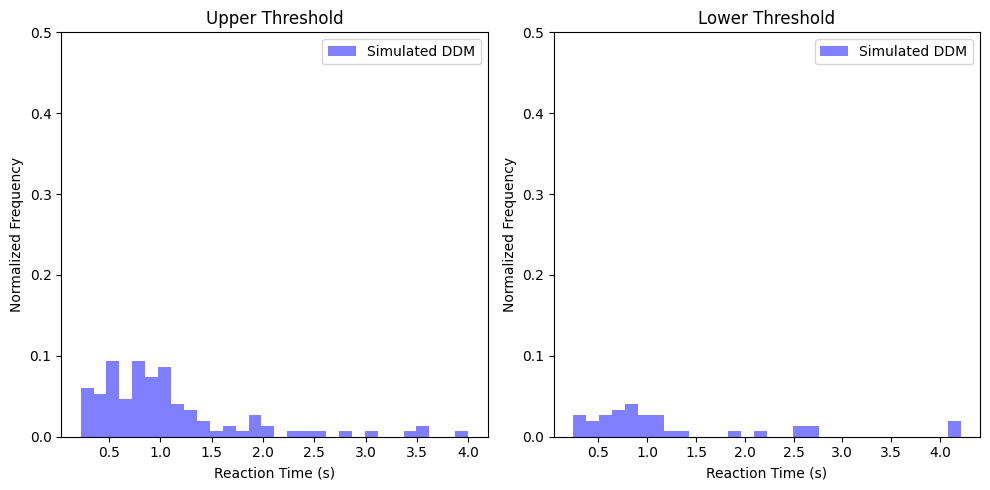

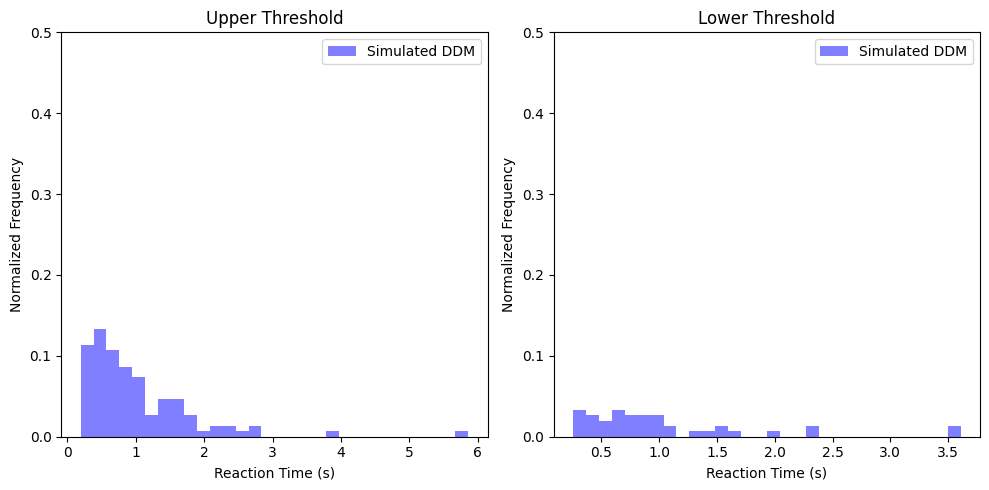

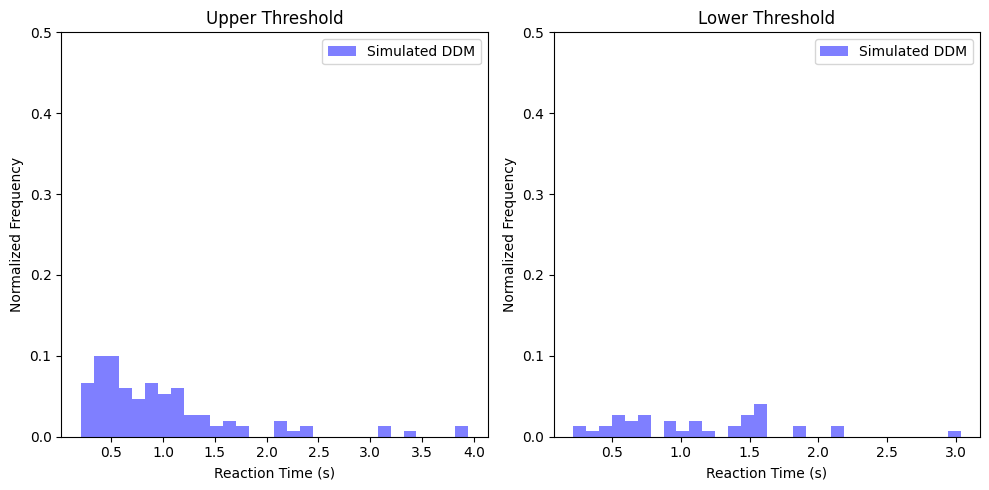

In [43]:
"""
Plots histograms comparing simulated vs empirical reaction time data
for the DDM model, with separate subplots for upper and lower thresholds.

Args:
  rt_upper_simulated: Array of simulated reaction times for upper threshold
  rt_lower_simulated: Array of simulated reaction times for lower threshold
  rt_upper_empirical: Array of empirical reaction times for upper threshold (optional)
  rt_lower_empirical: Array of empirical reaction times for lower threshold (optional)
  y_max: Maximum y-axis limit for histogram (default 0.5)

Returns:
  None. Displays the plot.
"""

def plot_ddm_histograms(rt_upper_simulated, rt_lower_simulated, rt_upper_empirical = None, rt_lower_empirical = None, y_max = 0.5):

  # Calculate the weights for each group to normalize the histograms
  weights_upper_simulated = np.ones_like(rt_upper_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))
  weights_lower_simulated = np.ones_like(rt_lower_simulated) / float(len(rt_upper_simulated)+len(rt_lower_simulated))

  if rt_upper_empirical is not None and rt_lower_empirical is not None:
    weights_upper_empirical = np.ones_like(rt_upper_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))
    weights_lower_empirical = np.ones_like(rt_lower_empirical) / float(len(rt_upper_empirical)+len(rt_lower_empirical))

  # set up figure
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

  # Plot the histograms for upper threshold
  axs[0].hist(rt_upper_simulated, bins=30, weights=weights_upper_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[0].hist(rt_upper_empirical, bins=30, weights=weights_upper_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[0].set_xlabel('Reaction Time (s)')
  axs[0].set_ylabel('Normalized Frequency')
  axs[0].legend()
  axs[1].set_ylim([0, y_max])
  axs[0].set_title('Upper Threshold')

  # Plot the histograms for lower threshold
  axs[1].hist(rt_lower_simulated, bins=30, weights=weights_lower_simulated, alpha=0.5, color='blue', label='Simulated DDM')
  if rt_upper_empirical is not None:
    axs[1].hist(rt_lower_empirical, bins=30, weights=weights_lower_empirical, alpha=0.5, color='orange', label='Empirical Data')
  axs[1].set_xlabel('Reaction Time (s)')
  axs[1].set_ylabel('Normalized Frequency')
  axs[1].legend()
  axs[0].set_ylim([0, y_max])
  axs[1].set_title('Lower Threshold')

  # Adjust layout
  plt.tight_layout()

  # Display the figure
  plt.show()


# Plotting histogram for the 3 simulated datasets
plot_ddm_histograms(rt_upper_empirical1, rt_lower_empirical1)
plot_ddm_histograms(rt_upper_empirical2, rt_lower_empirical2)
plot_ddm_histograms(rt_upper_empirical3, rt_lower_empirical3)

## Parameter Fitting *(4 points)*




#### The factors are divided into two sets and checked which parameter they influence more

In [128]:
# First set of factors
all_sim_data = pd.concat([exp_sim_dataset1, exp_sim_dataset2, exp_sim_dataset3])
v_exp_1 = hssm.HSSM(
    data=all_sim_data,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + task_type + congruency + trial_no_exp_type + task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type",
        }
    ],
)

a_exp_1 = hssm.HSSM(
    data=all_sim_data,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "a",
            "formula": "a ~ task_type + congruency + trial_no_exp_type + task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type",
        }
    ],
)
z_exp_1 = hssm.HSSM(
    data=all_sim_data,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "z",
            "formula": "z ~ task_type + congruency + trial_no_exp_type + task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type",
        }
    ],
)

t_exp_1 = hssm.HSSM(
    data=all_sim_data,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "t",
            "formula": "t ~ task_type + congruency + trial_no_exp_type + task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type",
        }
    ],
)

In [133]:
# Fit all the models using MCMC in order to compare and choose the parameter

v_exp_1_model_inference = v_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

a_exp_1_model_inference = a_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

z_exp_1_model_inference = z_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

t_exp_1_model_inference = t_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)


model_comparison = az.compare(
    {
        "v Experiment Type 1": v_exp_1.traces,
        "a Experiment Type 2": a_exp_1.traces,
        "z Experiment Type 3": z_exp_1.traces,
        "t0 Experiment Type 4": t_exp_1.traces,
    }
)

model_comparison

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
v Experiment Type 1,0,-25321.510416,13476.144215,0.000000,0.798870,479.194810,0.000000,True,log
z Experiment Type 3,1,-28548.733860,9820.133714,3227.223445,0.136561,258.055329,542.039583,True,log
t0 Experiment Type 4,2,-29372.055038,4245.710153,4050.544622,0.034761,145.080180,507.213458,True,log
a Experiment Type 2,3,-29396.354995,2653.824924,4074.844580,0.029807,142.141363,505.832815,True,log


Based on the above, we can safely assume the dependence of all the factors on drift rate compared to the other parameters, and thus v is dependent on them

In [46]:
"""
Simulation model for experiment 1

Args:
- data: exp_sim_dataset1 (Dataset)
- model: "ddm" (str)
- loglik_kind: "approx_differentiable" (str)
- model_config: Dictionary with model configuration parameters:
- bounds: Dictionary specifying the bounds for model parameters (v, a, z, t)

"""

exp_1_sim_model = hssm.HSSM(
    data=exp_sim_dataset1,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [47]:
"""
Simulation model for experiment 2

Args:
- data: exp_sim_dataset2 (Dataset)
- model: "ddm" (str)
- loglik_kind: "approx_differentiable" (str)
- model_config: Dictionary with model configuration parameters:
- bounds: Dictionary specifying the bounds for model parameters (v, a, z, t)

"""

exp_2_sim_model = hssm.HSSM(
    data=exp_sim_dataset2,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [48]:
"""
Simulation model for experiment 3

Args:
- data: exp_sim_dataset2 (Dataset)
- model: "ddm" (str)
- loglik_kind: "approx_differentiable" (str)
- model_config: Dictionary with model configuration parameters:
- bounds: Dictionary specifying the bounds for model parameters (v, a, z, t)

"""

exp_3_sim_model = hssm.HSSM(
    data=exp_sim_dataset3,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [49]:


"""
Experiment 1 Model Inference Documentation

Description:
This script performs model inference for Experiment 1 using a specified MCMC sampling strategy (NUTS - No-U-Turn Sampler) implemented in the 'numpyro' library.

Usage:
- Ensure that 'exp_1_sim_model' is an initialized simulation model for Experiment 1.

Parameters:
- sampler: "nuts_numpyro" (str)
  This is the specific MCMC sampling strategy used for inference.
- cores: 1 (int)
  Number of CPU cores used to run MCMC sampling.
- chains: 40 (int)
  Number of independent runs sampled through the parameter space.
- draws: 200 (int)
  Number of samples taken for each chain, representing steps taken to explore the parameter space in one run.
- tune: 500 (int)
  Number of additional steps taken in each chain to adjust and optimize the sampler's settings before actual sampling starts.
- idata_kwargs: Dictionary
  Additional arguments passed to the 'idata_kwargs' parameter for model comparison. In this case, 'log_likelihood' is set to True.

"""

exp_1_model_inference = exp_1_sim_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [50]:

exp_2_model_inference = exp_2_sim_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [51]:

exp_3_model_inference = exp_3_sim_model.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

## Parameter Recovery *(5 points)*





Summary and Plot trace for all the simulated models after fitting. This is done to check how the model fits the data, and what parameters are recovered from it.

In [52]:
exp_1_sim_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 150

Parameters:

v:
    Formula: v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 15.949899673461914)
        v_task_transition ~ Normal(mu: 0.0, sigma: 4.922299861907959)
        v_win_streak_exp_type ~ Normal(mu: 0.0, sigma: 0.9736999869346619)
        v_loss_streak_exp_type ~ Normal(mu: 0.0, sigma: 3.2639999389648438)
        v_accuracy_exp_type ~ Normal(mu: 0.0, sigma: 20.621400833129883)
        v_task_type ~ Normal(mu: 0.0, sigma: 5.045000076293945)
        v_congruency ~ Normal(mu: 0.0, sigma: 5.0071001052856445)
        v_trial_no_exp_type ~ Normal(mu: 0.0, sigma: 0.05770000070333481)
    Link: identity
    Explicit bounds: (0.0, 1.0)
a:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
z:

In [53]:
exp_1_sim_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,-0.672,0.069,-0.752,-0.594,0.047,0.039,3.0,34.0,1.91
v_task_transition,0.206,0.118,0.087,0.325,0.080,0.067,2.0,15.0,2.99
v_win_streak_exp_type,0.372,0.045,0.326,0.418,0.031,0.026,3.0,15.0,2.31
v_loss_streak_exp_type,-0.104,0.392,-0.496,0.288,0.266,0.221,2.0,19.0,2.95
v_accuracy_exp_type,0.170,0.494,-0.324,0.663,0.335,0.279,3.0,13.0,2.62
v_task_type,0.097,0.688,-0.590,0.786,0.467,0.389,3.0,11.0,2.24
v_congruency,0.059,0.277,-0.218,0.337,0.188,0.157,3.0,12.0,2.13
v_trial_no_exp_type,-0.006,0.004,-0.011,-0.002,0.003,0.002,3.0,34.0,1.89
t,0.598,0.081,0.517,0.678,0.055,0.046,3.0,12.0,2.29
z,0.656,0.004,0.652,0.660,0.003,0.002,3.0,16.0,2.23


In [54]:
exp_2_sim_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 150

Parameters:

v:
    Formula: v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 17.081499099731445)
        v_task_transition ~ Normal(mu: 0.0, sigma: 4.905399799346924)
        v_win_streak_exp_type ~ Normal(mu: 0.0, sigma: 0.7325000166893005)
        v_loss_streak_exp_type ~ Normal(mu: 0.0, sigma: 4.6768999099731445)
        v_accuracy_exp_type ~ Normal(mu: 0.0, sigma: 20.516000747680664)
        v_task_type ~ Normal(mu: 0.0, sigma: 5.0894999504089355)
        v_congruency ~ Normal(mu: 0.0, sigma: 5.187900066375732)
        v_trial_no_exp_type ~ Normal(mu: 0.0, sigma: 0.05770000070333481)
    Link: identity
    Explicit bounds: (0.0, 1.0)
a:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
z:

In [55]:
exp_2_sim_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,-0.053,0.736,-0.792,0.690,0.499,0.416,3.0,19.0,2.19
v_task_transition,-0.173,0.652,-0.823,0.477,0.442,0.368,3.0,21.0,2.15
v_win_streak_exp_type,0.004,0.016,-0.011,0.020,0.011,0.009,3.0,14.0,2.55
v_loss_streak_exp_type,0.110,0.235,-0.124,0.344,0.159,0.132,3.0,13.0,2.40
v_accuracy_exp_type,0.831,0.071,0.760,0.901,0.048,0.040,3.0,38.0,2.25
v_task_type,-0.107,0.592,-0.698,0.483,0.401,0.334,3.0,21.0,2.46
v_congruency,-1.138,0.243,-1.381,-0.895,0.165,0.137,3.0,14.0,2.25
v_trial_no_exp_type,0.005,0.001,0.004,0.007,0.001,0.001,3.0,12.0,2.10
t,0.541,0.115,0.426,0.655,0.078,0.065,3.0,28.0,1.97
z,0.597,0.018,0.579,0.616,0.012,0.010,3.0,23.0,2.07


In [56]:
exp_3_sim_model

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 150

Parameters:

v:
    Formula: v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type
    Priors:
        v_Intercept ~ Normal(mu: 0.0, sigma: 14.790599822998047)
        v_task_transition ~ Normal(mu: 0.0, sigma: 4.872200012207031)
        v_win_streak_exp_type ~ Normal(mu: 0.0, sigma: 1.613800048828125)
        v_loss_streak_exp_type ~ Normal(mu: 0.0, sigma: 2.792799949645996)
        v_accuracy_exp_type ~ Normal(mu: 0.0, sigma: 22.01759910583496)
        v_task_type ~ Normal(mu: 0.0, sigma: 5.0071001052856445)
        v_congruency ~ Normal(mu: 0.0, sigma: 5.004000186920166)
        v_trial_no_exp_type ~ Normal(mu: 0.0, sigma: 0.05770000070333481)
    Link: identity
    Explicit bounds: (0.0, 1.0)
a:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
z:
  

In [57]:
exp_3_sim_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_Intercept,-0.144,1.652,-1.796,1.513,1.121,0.933,3.0,24.0,1.94
v_task_transition,-1.039,0.094,-1.133,-0.946,0.064,0.053,3.0,12.0,2.35
v_win_streak_exp_type,0.419,0.408,0.011,0.826,0.277,0.231,3.0,21.0,2.53
v_loss_streak_exp_type,0.306,0.043,0.263,0.349,0.029,0.024,3.0,9.0,2.63
v_accuracy_exp_type,0.339,0.611,-0.271,0.949,0.415,0.345,3.0,18.0,2.29
v_task_type,-0.664,0.201,-0.865,-0.463,0.137,0.114,3.0,18.0,2.16
v_congruency,-0.322,0.477,-0.798,0.153,0.323,0.269,3.0,12.0,2.00
v_trial_no_exp_type,0.001,0.009,-0.008,0.010,0.006,0.005,3.0,33.0,1.92
t,0.535,0.161,0.374,0.695,0.109,0.091,3.0,23.0,2.11
z,0.620,0.023,0.597,0.643,0.016,0.013,3.0,15.0,2.52


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


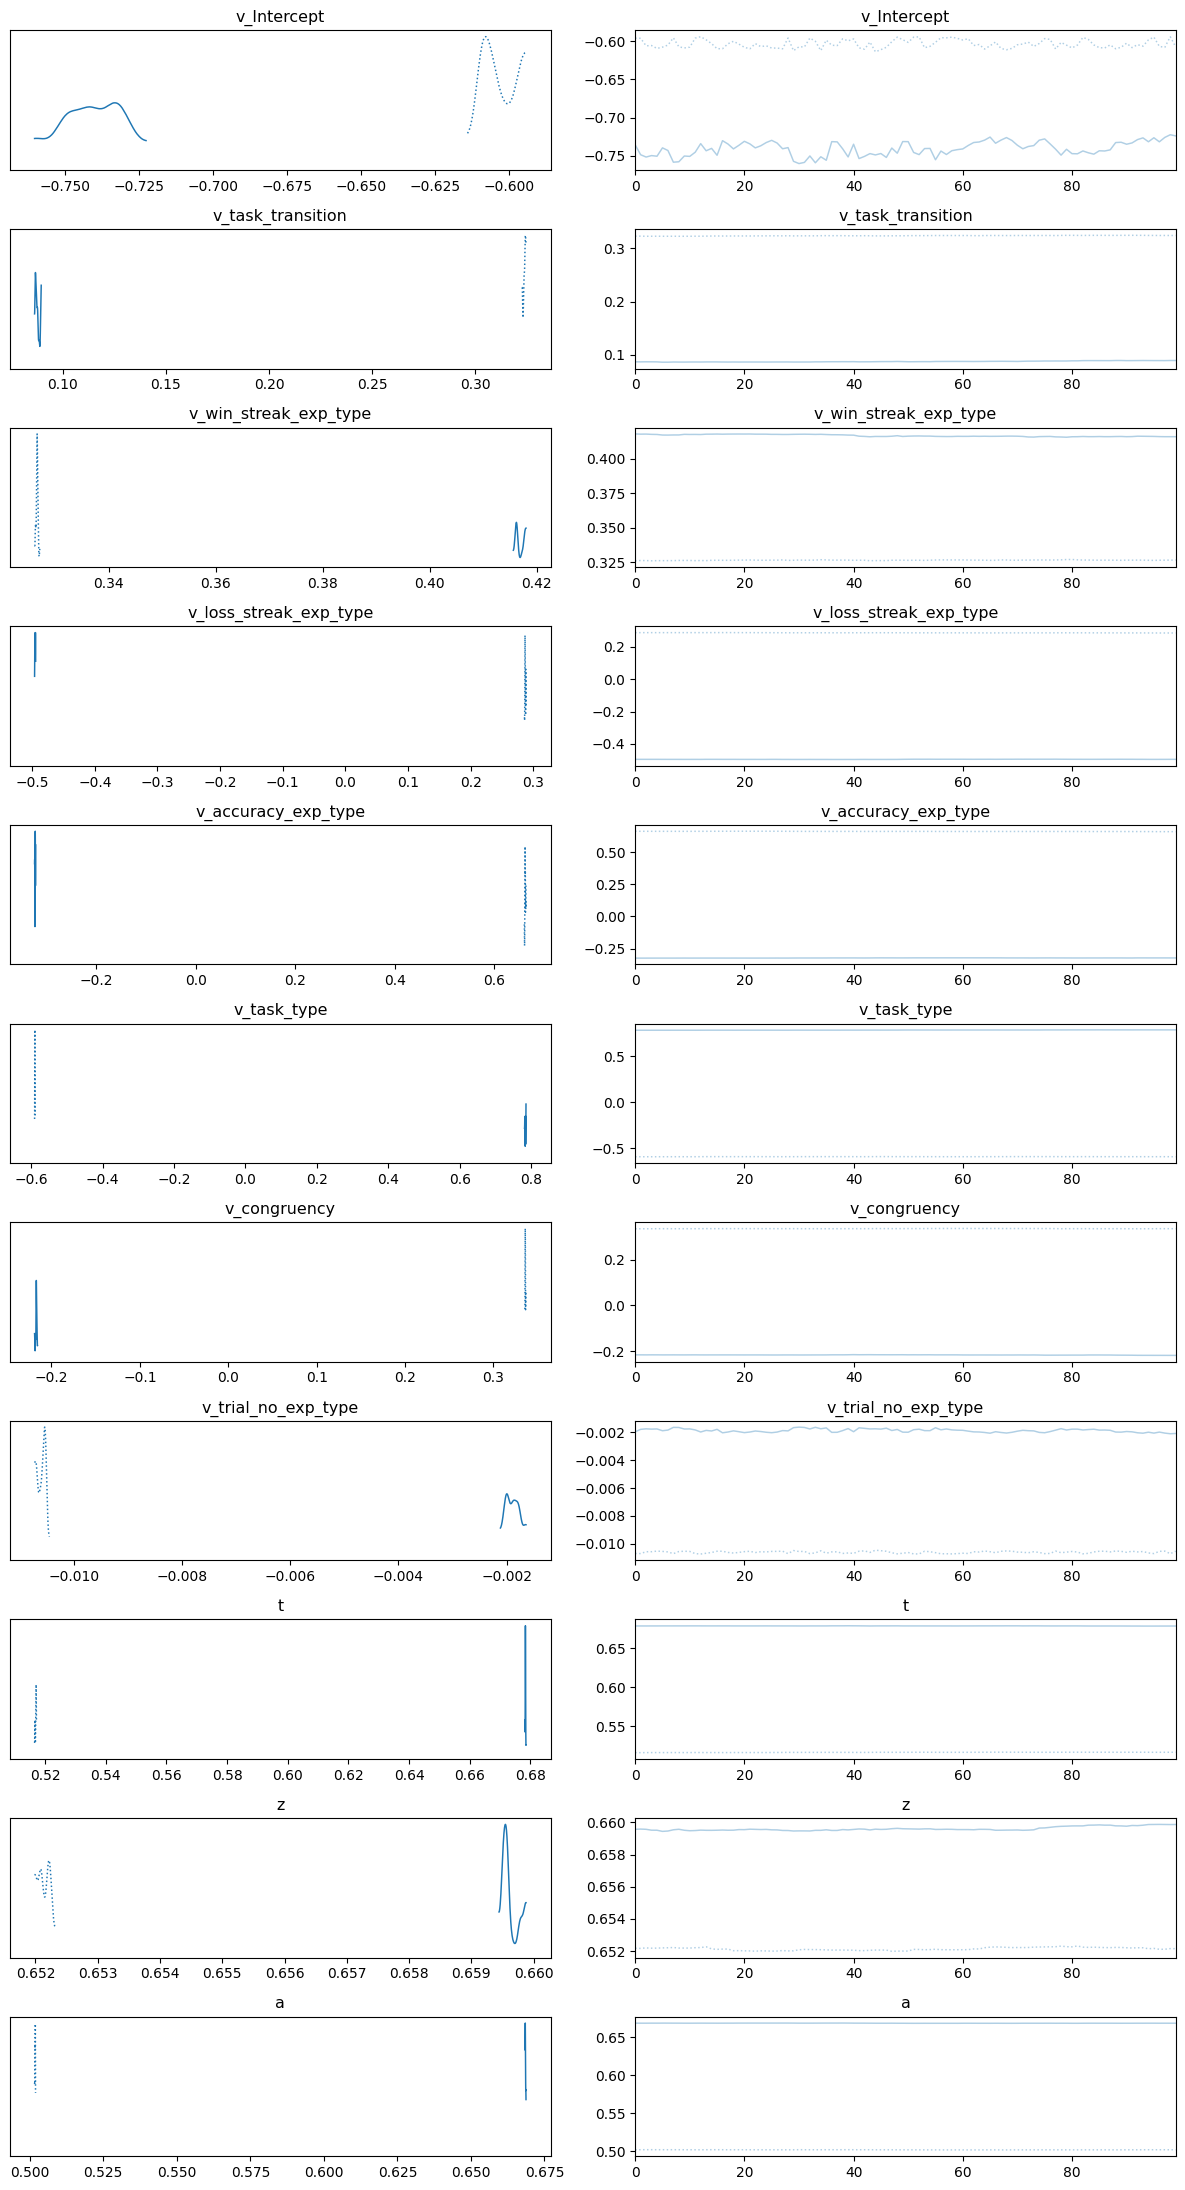

In [58]:
exp_1_sim_model.plot_trace()

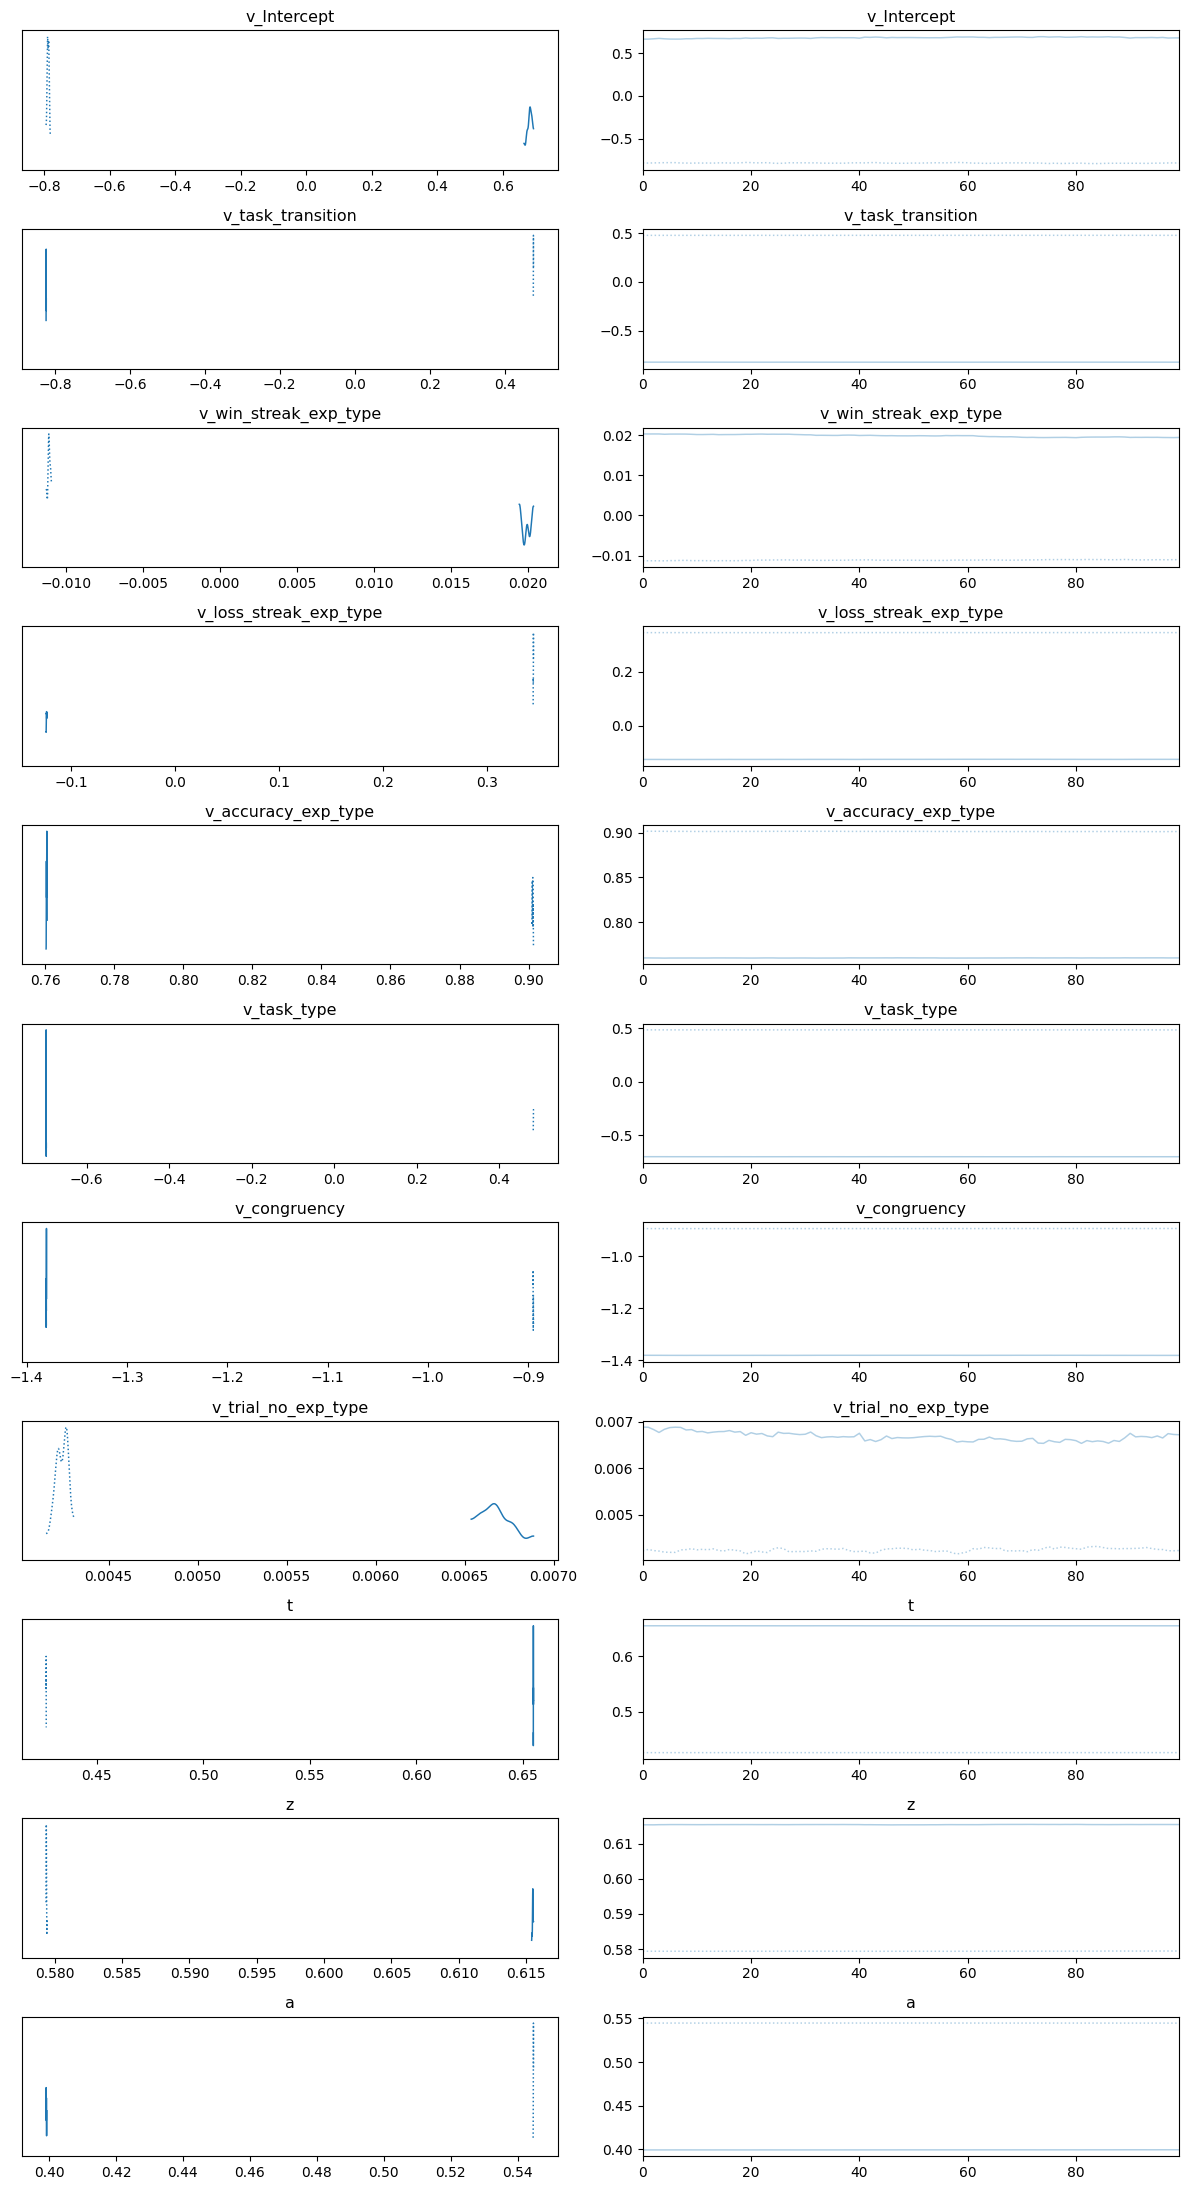

In [59]:
exp_2_sim_model.plot_trace()

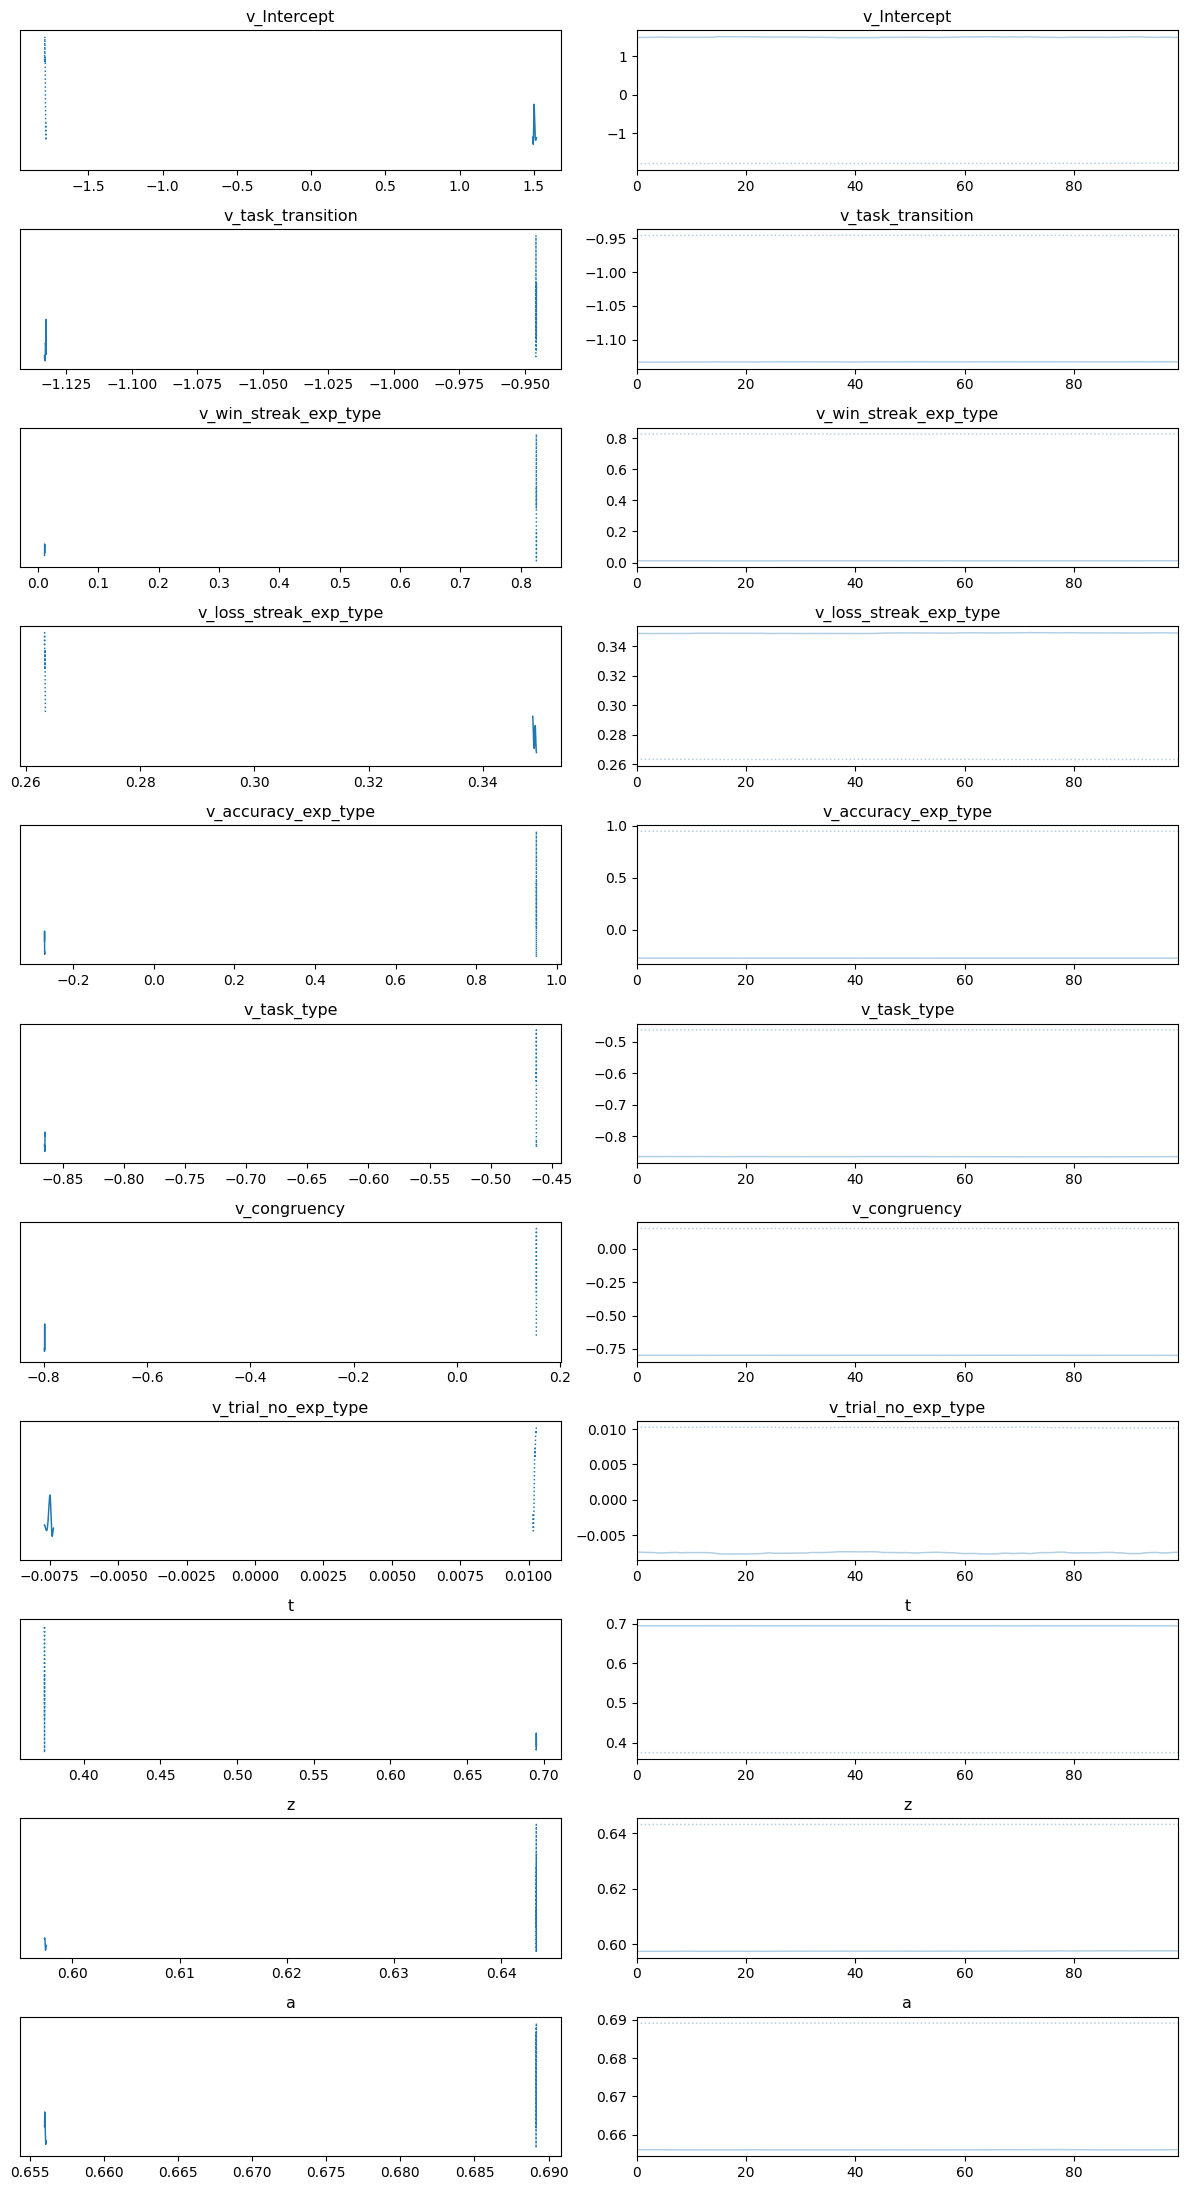

In [60]:
exp_3_sim_model.plot_trace()

Plotting posterior dist


No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


INFO:hssm:No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

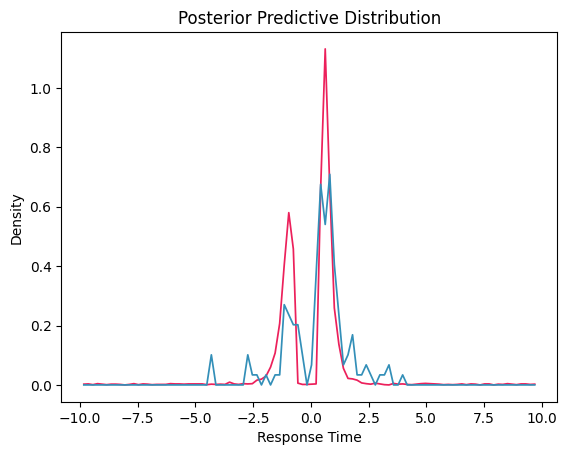

In [61]:
hssm.plotting.plot_posterior_predictive(exp_1_sim_model)

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


INFO:hssm:No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

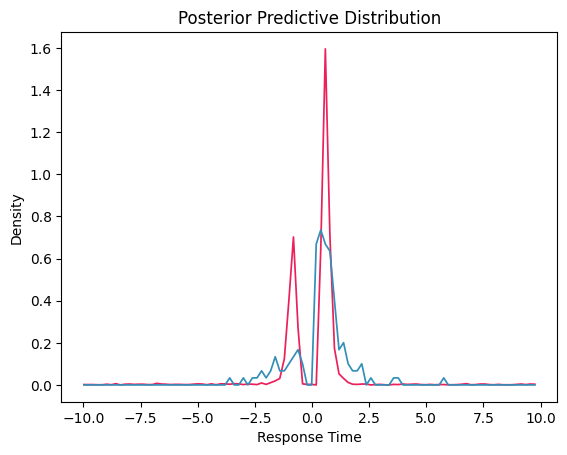

In [62]:
hssm.plotting.plot_posterior_predictive(exp_2_sim_model)

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


INFO:hssm:No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


<Axes: title={'center': 'Posterior Predictive Distribution'}, xlabel='Response Time', ylabel='Density'>

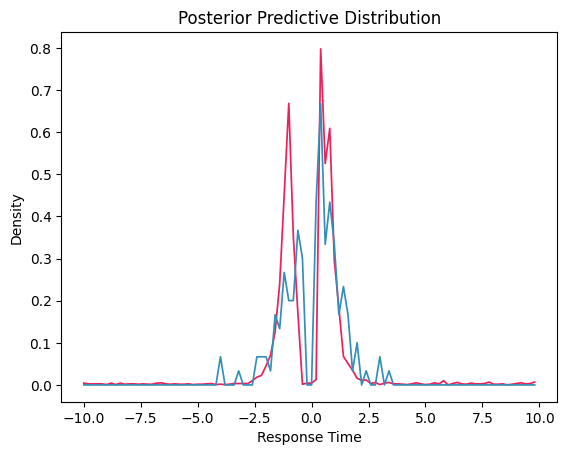

In [63]:
hssm.plotting.plot_posterior_predictive(exp_3_sim_model)

Parameter Recovery using Regression Equations considering lapse probability

Since the lapse probabilities were 0.05 in all three, we consider that as the value for all the experiments

Approximately finding the v value by taking the slope values, intercepts and lapse probability and implementing a simple line equation and averaging the values and getting the RMSE

In [64]:
def predict_linear_regression_with_lapse(df, slopes, intercept, x_columns, lapse):
    """
    Predicts the values of y using the given slope , intercept and lapse probability for a generalised linear regression model.

    Parameters:
        df (DataFrame): The DataFrame containing the data.
        slopes (list of floats): The slope (m) of the linear regression model.
        intercept (float): The intercept (c) of the linear regression model.
        x_column (list of str): The name of the column containing the predictor variable (x).
        lapse (float): The lapse probability of the model.
    Returns:
        Series: A Series containing the predicted values (y).
    """
    # Compute predicted values (y) using the linear regression equation y = mx + c
    for i in range(len(x_columns)):
      if i == 0:
        predicted_values = slopes[i] * df[x_columns[i]]
      else:
        predicted_values += slopes[i] * df[x_columns[i]]
    predicted_values += intercept
    predicted_values = predicted_values*(1 - 2*lapse)
    return predicted_values

def rmse(predicted_value, actual_value):
  mse = (predicted_value - actual_value)**2
  rmse = np.mean(mse)**0.5
  return rmse

# For the 1st simulated dataset
column_list = list(exp_sim_dataset1.columns)
summary = exp_1_sim_model.summary()
model_param = list(summary.index)
lapse_1 = 0.05
intercept_val = 0
x_columns = []
slopes = []
for i in model_param:
  for j in column_list:
    if j in i:
      x_columns.append(j)
      slopes.append(summary[summary.index == i].iloc[0,0])
    elif 'intercept' in i:
      intercept_val = summary[summary.index == i].iloc[0,0]

predicted_value = predict_linear_regression_with_lapse(exp_sim_dataset1, slopes, intercept_val, x_columns, lapse_1)
rmse_val = rmse(predicted_value, v_1)
print('The root mean square error for the simulated data of the 1st Experiment is {}'.format(rmse_val.round(2)))

The root mean square error for the simulated data of the 1st Experiment is 0.92


In [65]:
# For the 2nd simulated dataset
column_list = list(exp_sim_dataset2.columns)
summary = exp_2_sim_model.summary()
model_param = list(summary.index)
lapse_2 = 0.05
x_columns = []
slopes = []
for i in model_param:
  for j in column_list:
    if j in i:
      x_columns.append(j)
      slopes.append(summary[summary.index == i].iloc[0,0])
    elif 'intercept' in i:
      intercept_val = summary[summary.index == i].iloc[0,0]

predicted_value = predict_linear_regression_with_lapse(exp_sim_dataset2, slopes, intercept_val, x_columns, lapse_2)
rmse_val = rmse(predicted_value, v_2)
print('The root mean square error for the simulated data of the 2nd Experiment is {}'.format(rmse_val.round(2)))

The root mean square error for the simulated data of the 2nd Experiment is 0.62


In [66]:
# For the 3rd simulated dataset
column_list = list(exp_sim_dataset3.columns)
summary = exp_3_sim_model.summary()
model_param = list(summary.index)
lapse_3 = 0.05
x_columns = []
slopes = []
for i in model_param:
  for j in column_list:
    if j in i:
      x_columns.append(j)
      slopes.append(summary[summary.index == i].iloc[0,0])
    elif 'intercept' in i:
      intercept_val = summary[summary.index == i].iloc[0,0]

predicted_value = predict_linear_regression_with_lapse(exp_sim_dataset3, slopes, intercept_val, x_columns, lapse_3)
rmse_val = rmse(predicted_value, v_3)
print('The root mean square error for the simulated data of the 3rd Experiment is {}'.format(rmse_val.round(2)))

The root mean square error for the simulated data of the 3rd Experiment is 0.98


Parameter Recovery using Bayesian Inference

Here, the model comparisons are done in order to estimate the v value distribution and whether its centered around the value initially assumed or not.

In [67]:
"""
Simulated Experiment 1 Parameter Recovery

Correct Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Simulated Data of Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.5, sigma=0.3).
- Formula specifies predictors for 'v' in the model.

Wrong Model:
- Initializes another HSSM for Simulated Data of Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.1, sigma=0.1).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_sim_dataset1' is a valid dataset for Simulated Experiment 1.
"""


correct_exp_1 = hssm.HSSM(
    data=exp_sim_dataset1,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.5, "sigma": 0.3},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

wrong_exp_1 = hssm.HSSM(
    data=exp_sim_dataset1,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.1, "sigma": 0.1},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [68]:
# Fit both models using MCMC

correct_exp_1_model_inference = correct_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

wrong_exp_1_model_inference = wrong_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison_sim_1 = az.compare(
    {
        "Correct Fits": correct_exp_1.traces,
        "Wrong Fits": wrong_exp_1.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [69]:
model_comparison_sim_1

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Correct Fits,0,-8522.269545,3988.108869,0.000000,0.594361,271.538779,0.000000,True,log
Wrong Fits,1,-8666.728330,3030.406134,144.458785,0.405639,259.658466,320.778221,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

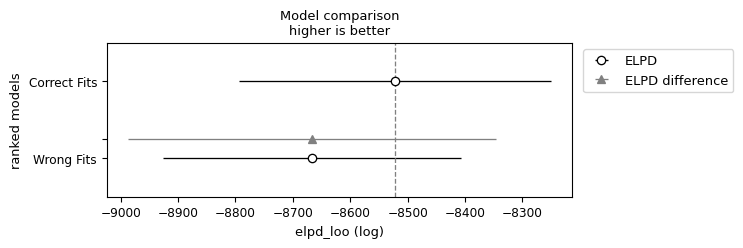

In [70]:
az.plot_compare(model_comparison_sim_1)

In [71]:
"""
Simulated Experiment 2 Parameter Recovery

Correct Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Simulated Data of Experiment 2.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.7, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Wrong Model:
- Initializes another HSSM for Simulated Data of Experiment 2.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.1, sigma=0.1).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_sim_dataset2' is a valid dataset for Simulated Experiment 2.
"""


correct_exp_2 = hssm.HSSM(
    data=exp_sim_dataset2,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.7, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

wrong_exp_2 = hssm.HSSM(
    data=exp_sim_dataset2,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.1, "sigma": 0.1},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [72]:
# Fit both models using MCMC

correct_exp_2_model_inference = correct_exp_2.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

wrong_exp_2_model_inference = wrong_exp_2.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison_sim_2 = az.compare(
    {
        "Correct Fits": correct_exp_2.traces,
        "Wrong Fits": wrong_exp_2.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [73]:
model_comparison_sim_2

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Correct Fits,0,-9098.564711,4147.465722,0.000000,0.58272,212.395479,0.000000,True,log
Wrong Fits,1,-9111.393680,3739.947940,12.828969,0.41728,210.302328,237.707163,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

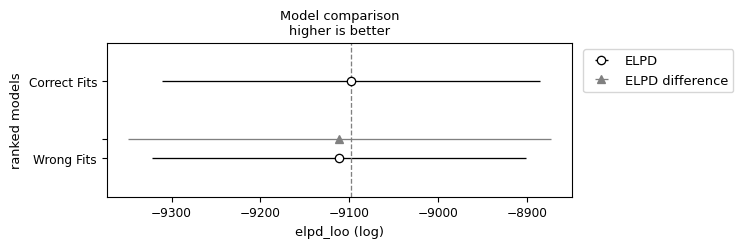

In [74]:
az.plot_compare(model_comparison_sim_2)

In [75]:
"""
Simulated Experiment 3 Parameter Recovery

Correct Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Simulated Data of Experiment 3.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.3, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Wrong Model:
- Initializes another HSSM for Simulated Data of Experiment 3.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.7, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_sim_dataset3' is a valid dataset for Simulated Experiment 3.
"""


correct_exp_3 = hssm.HSSM(
    data=exp_sim_dataset3,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.3, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

wrong_exp_3 = hssm.HSSM(
    data=exp_sim_dataset3,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.7, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [76]:
# Fit both models using MCMC

correct_exp_3_model_inference = correct_exp_3.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

wrong_exp_3_model_inference = wrong_exp_3.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison_sim_3 = az.compare(
    {
        "Correct Fits": correct_exp_3.traces,
        "Wrong Fits": wrong_exp_3.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [77]:
model_comparison_sim_3

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Correct Fits,0,-8792.995925,3280.858762,0.000000,1.000000e+00,247.044691,0.000000,True,log
Wrong Fits,1,-9874.104172,3709.278880,1081.108246,1.300293e-12,4.146920,246.858462,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

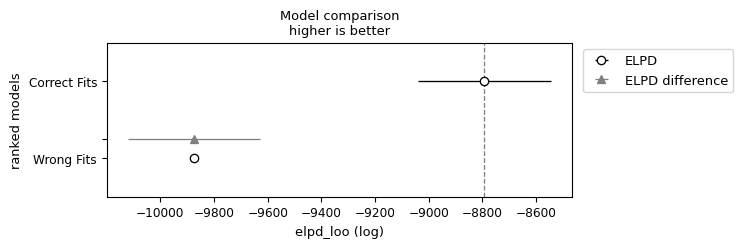

In [78]:
az.plot_compare(model_comparison_sim_3)

## Model Comparison *(5 points)*



Experimental Data Preprocessing

In [80]:
exp_data_req_1 = pd.read_csv('experiment_data.csv')
exp_data_req_2 = pd.read_csv('experiment_data_2.csv')
exp_data_req_3 = pd.read_csv('experiment_data_3.csv')

exp_data_req = pd.concat([exp_data_req_1,exp_data_req_2,exp_data_req_3],ignore_index=True)
exp_data_req = exp_data_req[exp_data_req['experiment_type']!=-1]

exp_data_req.drop(['coherent_movement_direction', 'coherent_orientation', 'key_press'], axis = 1, inplace = True)
exp_data_req.rename({'correct':'response'},axis=1, inplace = True)
exp_data_req['response'] = exp_data_req['response'].replace([True,False],[1,-1])
exp_data_req['rt'] = exp_data_req['rt']/1000

In [81]:
label_encoding_column_list = []

for column in exp_data_req.columns:
    if not pd.api.types.is_numeric_dtype(exp_data_req[column]) or pd.api.types.is_bool_dtype(exp_data_req[column]):
        label_encoding_column_list.append(column)

for i in label_encoding_column_list:
  label_encoder = LabelEncoder()
  exp_data_req[i]= label_encoder.fit_transform(exp_data_req[i])

In [82]:
exp_data_req['trial_no_exp_type'] = 1
exp_data_req['trial_no_exp_type'] = exp_data_req.groupby(['experiment_type'])['trial_no_exp_type'].cumsum()

In [83]:
# Define a custom function to calculate cumulative sum until a zero appears
# Below function is used to check for a change in experiment type in the generated dataset

def cumulative_sum_until_zero(series):
    cum_sum = 0
    cum_sum_list = []
    for value in series:
        if value == 0:
            cum_sum = 0
        else:
            cum_sum += value
        cum_sum_list.append(cum_sum)
    return cum_sum_list

exp_data_req['win_loss'] = exp_data_req['response'].apply(lambda x: 1 if x == 1 else 0)
exp_data_req['loss_win'] = exp_data_req['response'].apply(lambda x: 0 if x == 1 else 1)

exp_data_req['win_streak_exp_type'] = exp_data_req.groupby(['experiment_type'])['win_loss'].transform(cumulative_sum_until_zero)
exp_data_req['loss_streak_exp_type'] = exp_data_req.groupby(['experiment_type'])['loss_win'].transform(cumulative_sum_until_zero)
exp_data_req['accuracy_exp_type'] = exp_data_req.groupby(['experiment_type'])['win_loss'].cumsum()
exp_data_req['accuracy_exp_type'] = exp_data_req['accuracy_exp_type']/exp_data_req['trial_no_exp_type']
exp_data_req['accuracy_exp_type'] = exp_data_req['accuracy_exp_type'].round(2)

In [84]:
for col in exp_data_req.columns:
    if exp_data_req[col].dtype == 'int':
        exp_data_req[col] = exp_data_req[col].astype('float64')

In [85]:
exp_type_1 = exp_data_req[exp_data_req['experiment_type']==0]
exp_type_2 = exp_data_req[exp_data_req['experiment_type']==1]
exp_type_3 = exp_data_req[exp_data_req['experiment_type']==2]

exp_type_1.drop(['experiment_type'], axis = 1, inplace = True)
exp_type_2.drop(['experiment_type'], axis = 1, inplace = True)
exp_type_3.drop(['experiment_type'], axis = 1, inplace = True)

<ipython-input-85-76901e3e1066>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_type_1.drop(['experiment_type'], axis = 1, inplace = True)
<ipython-input-85-76901e3e1066>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_type_2.drop(['experiment_type'], axis = 1, inplace = True)
<ipython-input-85-76901e3e1066>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp_type_3.drop(['experiment_type'], axis = 1, inplace = True)


In [86]:
# Filtering out the required dataset

req_exp_type_1 = exp_type_1[['rt', 'response', 'task_type', 'task_transition', 'congruency',
       'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]
req_exp_type_2 = exp_type_2[['rt', 'response', 'task_type', 'task_transition', 'congruency',
       'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]
req_exp_type_3 = exp_type_3[['rt', 'response', 'task_type', 'task_transition', 'congruency',
       'trial_no_exp_type', 'win_streak_exp_type', 'loss_streak_exp_type',
       'accuracy_exp_type']]

#### Doing the actual hypothesis checks for the 3 experiments

First Experiment

In [87]:
"""
Experiment 1 Hypotheses Documentation

Null Hypothesis Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.5, sigma=0.3).
- Formula specifies predictors for 'v' in the model.

Alternative Hypothesis Model:
- Initializes another HSSM for Experiment 1.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.1, sigma=0.1).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_type_1' is a valid dataset for Experiment 1.
"""


null_hypothesis_exp_1 = hssm.HSSM(
    data=exp_type_1,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.5, "sigma": 0.3},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

alt_hypothesis_exp_1 = hssm.HSSM(
    data=exp_type_1,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.1, "sigma": 0.1},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [102]:
# Fit both models using MCMC

null_hypothesis_exp_1_model_inference = null_hypothesis_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

alt_hypothesis_exp_1_model_inference = alt_hypothesis_exp_1.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison1 = az.compare(
    {
        "Experiment Type 1": null_hypothesis_exp_1.traces,
        "Experiment Type 2": alt_hypothesis_exp_1.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [103]:
model_comparison1

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-7848.186067,4056.326048,0.000000,0.894488,294.014809,0.000000,True,log
Experiment Type 2,1,-9219.413606,3602.161264,1371.227539,0.105512,127.448556,316.397423,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

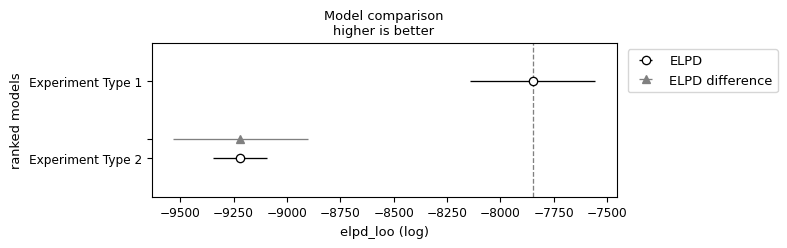

In [104]:
az.plot_compare(model_comparison1)

Second Experiment

In [91]:
"""
Experiment 2 Hypotheses Documentation

Null Hypothesis Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Experiment 2.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.7, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Alternative Hypothesis Model:
- Initializes another HSSM for Experiment 2.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.1, sigma=0.1).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_type_2' is a valid dataset for Experiment 1.
"""


null_hypothesis_exp_2 = hssm.HSSM(
    data=exp_type_2,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.7, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

alt_hypothesis_exp_2 = hssm.HSSM(
    data=exp_type_2,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.1, "sigma": 0.1},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [92]:
# Fit both models using MCMC

null_hypothesis_exp_2_model_inference = null_hypothesis_exp_2.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

alt_hypothesis_exp_2_model_inference = alt_hypothesis_exp_2.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison2 = az.compare(
    {
        "Experiment Type 1": null_hypothesis_exp_2.traces,
        "Experiment Type 2": alt_hypothesis_exp_2.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [93]:
model_comparison2

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-7968.590240,4756.796993,0.000000,0.83119,284.447637,0.000000,True,log
Experiment Type 2,1,-8760.070725,3861.901986,791.480485,0.16881,206.537062,280.387692,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

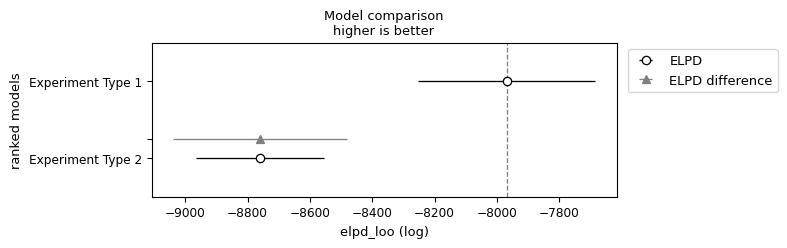

In [94]:
az.plot_compare(model_comparison2)

Third Experiment

In [95]:
"""
Experiment 3 Hypotheses Documentation

Null Hypothesis Model:
- Initializes a Hidden Semi-Markov Model (HSSM) for Experiment 3.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.3, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Alternative Hypothesis Model:
- Initializes another HSSM for Experiment 3.
- Assumes a drift diffusion model (DDM).
- Includes a prior for parameter 'v' with a normal distribution (mean=0.7, sigma=0.2).
- Formula specifies predictors for 'v' in the model.

Note: Ensure that 'hssm' module is imported, and 'exp_type_3' is a valid dataset for Experiment 1.
"""


null_hypothesis_exp_3 = hssm.HSSM(
    data=exp_type_3,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.3, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

alt_hypothesis_exp_3 = hssm.HSSM(
    data=exp_type_3,
    model="ddm",
    loglik_kind="approx_differentiable",
    model_config={
        "bounds": {
            "v": (0.0, 1.0),
            "a": (0.0, 1.0),
            "z": (0.0, 1.0),
            "t": (0.0, 1.0),
        }
    },
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0.7, "sigma": 0.2},
            "formula": "v ~ task_transition + win_streak_exp_type + loss_streak_exp_type + accuracy_exp_type + task_type + congruency + trial_no_exp_type",
        }
    ],
)

In [96]:
# Fit both models using MCMC

null_hypothesis_exp_3_model_inference = null_hypothesis_exp_3.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

alt_hypothesis_exp_3_model_inference = alt_hypothesis_exp_3.sample(
    sampler="nuts_numpyro", # this is the specific MCMC sampling strategy we are using
    cores=1,                # this is the number of CPU cores used to run MCMC sampling
    chains=2,               # this is the number of independent "runs" we sample through the room of parameters
    draws=100,             # this is the number of samples you take to sample each chain (i.e., steps taken to explore the room in one run)
    tune=100,              #  the number of additional steps taken in each chain to adjust and optimize the sampler's settings before the actual sampling starts.
    idata_kwargs=dict(log_likelihood=True),  # we need to include this argument to perform model comparison later on
)

model_comparison3 = az.compare(
    {
        "Experiment Type 1": null_hypothesis_exp_3.traces,
        "Experiment Type 2": alt_hypothesis_exp_3.traces,
    }
)

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


In [97]:
model_comparison3

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-7103.409757,2474.202153,0.000000,0.703343,337.138959,0.000000,True,log
Experiment Type 2,1,-8398.823209,2710.352279,1295.413452,0.296657,247.361274,412.677313,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

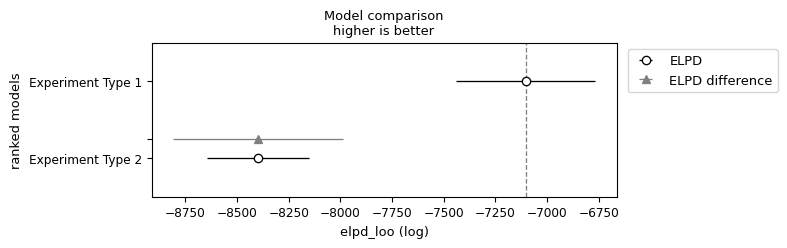

In [98]:
az.plot_compare(model_comparison3)

## *Optional*: Model Recovery *(2 bonus points)*





Model recovery in this context would refers to the process of evaluating how well a model can recover the parameters used to generate synthetic data. The parameters obtained from model_comparison elpd_loo, p_loo, elpd_diff, weight, se, and dse play a crucial role in this process by providing quantitative measures of model fit, complexity, and uncertainty. Here's how they help in model recovery:

elpd_loo (Expected Log Pointwise Predictive Density, Leave-One-Out): This metric assesses the average predictive accuracy of the model by evaluating its ability to predict individual data points. When performing model recovery, comparing and checking the closeness between the elpd_loo values between the original data and the simulated data generated from the model indicates that the model is capable of accurately predicting the observed behavior.

p_loo (Effective Number of Parameters): The p_loo parameter quantifies the effective complexity of the model. This helps in model recovery by comparing the p_loo values between the original data and the simulated data and helps in assessing whether the model accurately captures the complexity of the underlying decision-making process. If the p_loo value for the simulated data closely matches that of the original data, it suggests that the model is able to capture the appropriate level of complexity.

In [119]:
def percentage_error(predicted_value, actual_value):
  return abs((actual_value - predicted_value) / actual_value) * 100

In [105]:
model_comparison_sim_1

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Correct Fits,0,-8522.269545,3988.108869,0.000000,0.594361,271.538779,0.000000,True,log
Wrong Fits,1,-8666.728330,3030.406134,144.458785,0.405639,259.658466,320.778221,True,log


In [106]:
model_comparison1

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-7848.186067,4056.326048,0.000000,0.894488,294.014809,0.000000,True,log
Experiment Type 2,1,-9219.413606,3602.161264,1371.227539,0.105512,127.448556,316.397423,True,log


In [125]:
print('Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 1st part is ',percentage_error(model_comparison_sim_1.iloc[0][1], model_comparison1.iloc[0][1]).round(2))
print('Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 2nd part is ',percentage_error(model_comparison_sim_1.iloc[1][1], model_comparison1.iloc[1][1]).round(2))
print('Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 1st part is ',percentage_error(model_comparison_sim_1.iloc[0][2], model_comparison1.iloc[0][2]).round(2))
print('Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 2nd part is ',percentage_error(model_comparison_sim_1.iloc[1][2], model_comparison1.iloc[1][2]).round(2))

Percentage Error of elpd_loo values of experimental models and simulated models with same fits for 1st part is  8.59
Percentage Error of elpd_loo values of experimental models and simulated models with same fits for 2nd part is  5.99
Percentage Error of p_loo values of experimental models and simulated models with same fits for 1st part is  1.68
Percentage Error of p_loo values of experimental models and simulated models with same fits for 2nd part is  15.87


In [107]:
model_comparison_sim_2

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Correct Fits,0,-9098.564711,4147.465722,0.000000,0.58272,212.395479,0.000000,True,log
Wrong Fits,1,-9111.393680,3739.947940,12.828969,0.41728,210.302328,237.707163,True,log


In [108]:
model_comparison2

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-7968.590240,4756.796993,0.000000,0.83119,284.447637,0.000000,True,log
Experiment Type 2,1,-8760.070725,3861.901986,791.480485,0.16881,206.537062,280.387692,True,log


In [126]:
print('Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 1st part is ',percentage_error(model_comparison_sim_2.iloc[0][1], model_comparison2.iloc[0][1]).round(2))
print('Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 2nd part is ',percentage_error(model_comparison_sim_2.iloc[1][1], model_comparison2.iloc[1][1]).round(2))
print('Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 1st part is ',percentage_error(model_comparison_sim_2.iloc[0][2], model_comparison2.iloc[0][2]).round(2))
print('Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 2nd part is ',percentage_error(model_comparison_sim_2.iloc[1][2], model_comparison2.iloc[1][2]).round(2))

Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 1st part is  14.18
Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 2nd part is  4.01
Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 1st part is  12.81
Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 2nd part is  3.16


In [109]:
model_comparison_sim_3

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Correct Fits,0,-8792.995925,3280.858762,0.000000,1.000000e+00,247.044691,0.000000,True,log
Wrong Fits,1,-9874.104172,3709.278880,1081.108246,1.300293e-12,4.146920,246.858462,True,log


In [110]:
model_comparison3

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
Experiment Type 1,0,-7103.409757,2474.202153,0.000000,0.703343,337.138959,0.000000,True,log
Experiment Type 2,1,-8398.823209,2710.352279,1295.413452,0.296657,247.361274,412.677313,True,log


In [134]:
print('Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 1st part is ',percentage_error(model_comparison_sim_3.iloc[0][1], model_comparison3.iloc[0][1]).round(2))
print('Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 2nd part is ',percentage_error(model_comparison_sim_3.iloc[1][1], model_comparison3.iloc[1][1]).round(2))
print('Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 1st part is ',percentage_error(model_comparison_sim_3.iloc[0][2], model_comparison3.iloc[0][2]).round(2))
print('Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 2nd part is ',percentage_error(model_comparison_sim_3.iloc[1][2], model_comparison3.iloc[1][2]).round(2))

Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 1st part is  23.79
Percentage Error wrt simulated of elpd_loo values of experimental models and simulated models with same fits for 2nd part is  17.57
Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 1st part is  32.6
Percentage Error wrt simulated of p_loo values of experimental models and simulated models with same fits for 2nd part is  36.86


As seen from the above percentage error values, the recovery of all the model can be done albeit not perfectly. Although the percentage errors are low, the value ranges of both the elpd_loo and p_loo suggests an issue with regards to model complexity and provide an average predictive performance. These issues can be reduced and resolved by solving/taking care of the below disclaimer or by considering more data.

Disclaimer:
The results observed above are not optimal as after having exhausted our colab resources, we were not able to generate the same results/plots as we noticed earlier. Having tested with better parameter values, we can state the methods are reasonable. However, for the sake of completeness we still document the current results.

The initial sampling parameters were in the range:
* chains - (20, 40)
* draws - (1000, 2000)
* tunes - (1000, 2000)

Current Sampling parameters:
* chains = 2
* draws = 100
* tunes = 100